# ISM as the smallest sampled set of data points to approximate the NN around the sequence of interest
In silico saturation mutagenesis samples exactly 3 X L data points around the sequence of input, in the maximally close vicinity to estimate the linear coefficients of the surrogate model. Since only one base is perturbed at the time, ISM enables direct estimation of the linear coefficients for each position from just three pertubations.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import time
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

from tism.models import Beluga
from tism.utils import plot_attribution, ism, deepliftshap
from tism.torch_grad import correct_multipliers, takegrad

from tangermeme.utils import random_one_hot
from tangermeme.ersatz import substitute

# Download from https://zenodo.org/record/3402406/files/deepsea.beluga.pth
parameters = '../data/deepsea.beluga.pth'
model = Beluga()
model.load_state_dict(torch.load(parameters))
model.eval()
    
N=1 # number of sequences
b=4 # number of bases
input_length = 2000 
    
x = random_one_hot((N, b, input_length), random_state = 1).type(torch.float32)
x = substitute(x, "CTCAGTGATG")
x = x.detach().cpu().numpy()
    
track = 267 # is the JUN TF CHIP-seq track
vis_seq = 0

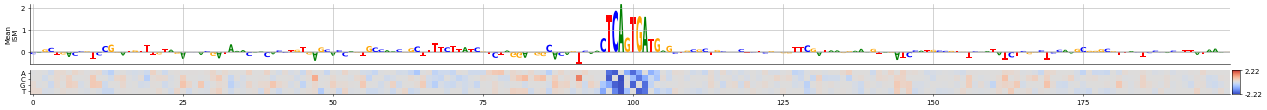

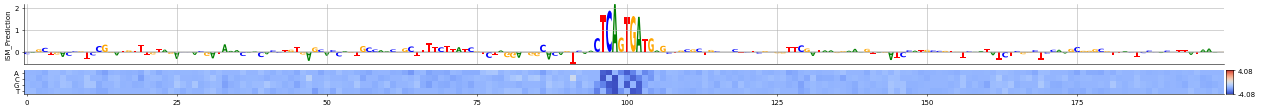

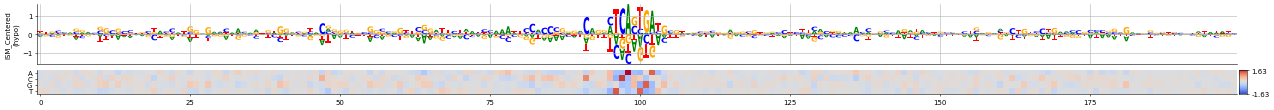

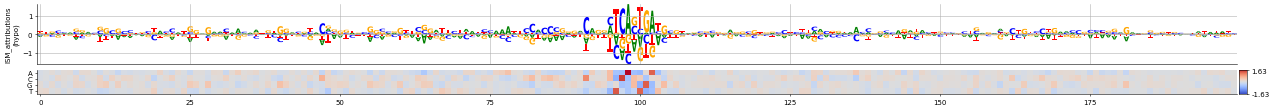

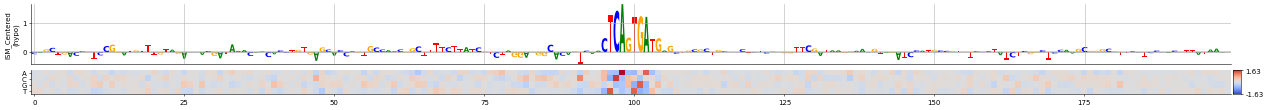

In [5]:
# ISM values for each base are prediction_alternative - prediction_reference 
ism_array = ism(x, model, tracks = track, output = 'ism', batch_size=128, start = 900, end = 1100, device='cuda:0')
# prediction for reference and alternative sequences can be returned with 
ism_predictions = ism(x, model, tracks = track, output = 'predictions', batch_size=128, start = 900, end = 1100, device='cuda:0')

ism0 = ism_array[vis_seq,0]
# compute ism meaneffect across all for plotting
meaneffect_ism = -np.sum(ism0/3, axis = -2)[None,:] * x[vis_seq]
fig_ism = plot_attribution(meaneffect_ism[...,900:1100], heatmap = ism0[...,900:1100], ylabel = 'Mean\nISM')

# ism predictions can be transformed to ism values by subtracting the reference prediction
ismpred0 = ism_predictions[vis_seq,0]
ismpred0array = ismpred0 - (ismpred0 * x[vis_seq]).sum(axis = -2)[None,:]
ismpred0arraymean = -np.sum(ismpred0array/3, axis = -2)[None,:] * x[vis_seq]
fig_ismpred = plot_attribution(ismpred0arraymean[...,900:1100], heatmap = ismpred0[...,900:1100], ylabel = 'ISM_Prediction')

# Hypothetical attributions to uniform baseline are equivalent to centered ISM 
ism_hypothetical = correct_multipliers(ism_array, 'corrected')
ism_hypo0 = ism_hypothetical[vis_seq,0]
fig_ismhyp0 = plot_attribution(ism_hypo0[...,900:1100], heatmap = ism_hypo0[...,900:1100], ylabel = 'ISM_Centered\n(hypo)')
# They can also be computed directly from the ism function
ism_attributions = ism(x, model, tracks = track, output = 'ism_attributions', batch_size=128, start = 900, end = 1100, device='cuda:0')
ism_hypo0 = ism_attributions[vis_seq,0]
fig_ismatt = plot_attribution(ism_hypo0[...,900:1100], heatmap = ism_hypo0[...,900:1100], ylabel = 'ISM_attributions\n(hypo)')

# Normally, we only want to look at the attributions from the reference sequence bases
fig_ismhyp_ref = plot_attribution(ism_hypo0[...,900:1100]* x[vis_seq][...,900:1100], heatmap = ism_hypo0[...,900:1100], ylabel = 'ISM_Centered\n(hypo)')
